## Exploring the Quantum Approximate Optimization Algorithm

In this notebook we shall review the QAOA for the typical problem of MaxCut.

The QAOA is designed to solve binary combinatorial optimization problems.
The term binary means that the instances of the problem are bitstrings. Combinatorial optimization consists in the search of an optimal solution, maximizing or minimizing a production (or cost) function among a set of finite instances.

The objective of this notebook is to implement the basic components of the algorithm.

In [1]:
## Necessary functions and input
%matplotlib inline
# useful additional packages 

#import math tools
import numpy as np
import random as rand
# We import the tools to handle general Graphs
import networkx as nx
from scipy.optimize import fmin, minimize,differential_evolution,brute
from qiskit.aqua.components.optimizers import COBYLA, SPSA, SLSQP
# We import plotting tools 
import matplotlib.pyplot as plt 
from   matplotlib import cm
from   matplotlib.ticker import LinearLocator, FormatStrFormatter
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

# importing Qiskit
from qiskit import Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute

from qiskit.providers.ibmq      import least_busy
from qiskit.tools.monitor       import job_monitor
from qiskit.visualization import plot_histogram
#IBMQ.save_account('b4c22f9da67ce0063a7cf1b2666f87fcb3641addb701a8cb1d9f9acd86a9ebfc3e988ab715fa2371432551b983934805a5dbe0c54b249d1f3047e00f304b8663')
#provider = IBMQ.load_account()
from qiskit.visualization import plot_histogram
import qiskit.providers.aer.noise as noise
π=np.pi

/Users/arthurstrauss/anaconda3/envs/qiskit_env/lib/python3.9/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')


We will use the QAOA to calculate the Maximum cut of an arbitrary graph G, that you can define below


In [2]:
def cost_function_C(x,G): 
    """
    Compute here the cost function associated to the graph G (see how it is generated below)
    x is the bitstring on which shall be evaluated the cost
    """
    cost = 0
    
    return cost

def QAOA_circuit(γ,β,G):
    """
    Define the QAOA quantum circuit in Qiskit to generate the trial state
    γ,β should be both lists of equal size, composed of real parameters taking values in
    [0,2π].
    """
    n = len(G.nodes()) # Number of qubits
    p = len(γ) # Hyperparameter defining the circuit depth
    
    QAOA=QuantumCircuit(n, n)
    "Complete the circuit"
    
    return QAOA

                 
        


Below we define the functions necessary to perform the classical part of this VQA.
When the quantum circuit becomes too deep to be evaluated classically, or when the connectivity of the Problem Hamiltonian is too high we can resort to other means of estimating the expectation value. This involves directly estimating $F_{p}(\vec{\gamma}, \vec{\beta})=\langle\psi_{p}(\vec{\gamma}, \vec{\beta})|H| \psi_{p}(\vec{\gamma}, \vec{\beta})\rangle$ on the quantum computer. The approach here follows the path of the conventional expectation value estimation as used in VQE, where a trial state $|\psi_{p}(\vec{\gamma}, \vec{\beta})\rangle$
 is prepared directly on the quantum computer and the expectation value is obtained from sampling.
 
 Since QAOA has a diagonal Hamiltonian $H$,
it is actually straight forward to estimate the expectation value. We only need to obtain samples from the trial state in the computational basis. Recall that $H=\sum_{x \in\{0,1\}^{n}} C(x)|x\rangle\langle x|$
so that we can obtain the sampling estimate of 
$$
\left\langle\psi_{p}(\vec{\gamma}, \vec{\beta})|H| \psi_{p}(\vec{\gamma}, \vec{\beta})\right\rangle=\sum_{x \in\{0,1\}^{n}} C(x)\left|\left\langle x \mid \psi_{p}(\vec{\gamma}, \vec{\beta})\right\rangle\right|^{2}
$$

by repeated single qubit measurements of the state $\psi_{p}(\vec{\gamma}, \vec{\beta})$ in the $Z$ basis. For every bit string $x$ obtained from the distribution $\left|\left\langle x \mid \psi_{p}(\vec{\gamma}, \vec{\beta})\right\rangle\right|^{2}$ we evaluate the cost function $C(x)$ and average it over the total number of samples. The resulting empirical average approximates the expectation value up to an additive sampling error that lies within the variance of the state.
Complete below the function computation to retrieve this expectation value.
We provide the optimization part using classical optimizers with the function optimization_routine.

In [3]:
def computation(angles, G, backend=Aer.get_backend("qasm_simulator"), shots=10000):
        
    l = len(angles)
    γ = angles[0:l:2]
    β = angles[1:l:2]
    Circuit = QAOA_circuit(γ, β, G)
    job = execute(backend=backend,shots=shots)
    QAOA_results = job.result()
    counts = QAOA_results.get_counts()
    
    Expectation_value = 0
    
    """
    Complete here the calculation of the expectation value (cost function) 
    to be optimized 
    """
    return Expectation_value

In [8]:
def optimization_routine(p, G, optimizer = 'Nelder-Mead', backend=Aer.get_backend("qasm_simulator"), shots = 10000):

    min_bound=[0.] * 2*p
    max_bound=[2*π, π] * p
    boundaries = [(min_bound[i], max_bound[i]) for i in range(2*p)]

    # Initialize random angles
    angles=[]
    for _ in range(p):
        angles.append(rand.uniform(0, 2 * π))
        angles.append(rand.uniform(0, π))

    if (optimizer=='brute'):
        opti_angles,expminus=brute(func=computation,ranges=boundaries,args=(G, backend, shots),Ns=10,finish=fmin)
        exp = -expminus

    elif (optimizer=='differential_evolution'):
        Opti_Result= differential_evolution(computation,bounds=boundaries,args=(G, backend, shots),tol=0.1)
        opti_angles= Opti_Result.x
        exp = -Opti_Result.fun

    elif (optimizer=='SPSA'):
        op=SPSA()
        op.wrap_function(computation,(G,backend, shots))
        opti_angles, expminus,nfv=op.optimize(len(angles),computation,variable_bounds=boundaries,initial_point=angles)
        exp.append = -expminus

    else:
        Opti_Result=minimize(fun=computation,x0=angles,args=(G,backend,10000,prob),method= optimizer,
                    bounds=boundaries)
        opti_angles = Opti_Result.x
        exp = -Opti_Result.fun
            
    print("Optimization done")
    return exp,opti_angles
    
    

## Definition of the graph


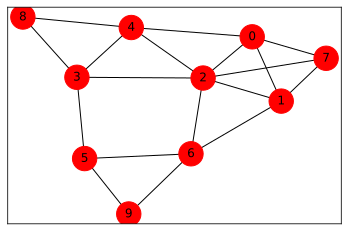

In [9]:
n     = 10
V     = np.arange(0,n,1)
E     =[(0,1,1.0),(0,2,1.0),(1,2,1.0),(3,2,1.0),(3,4,1.0),(4,2,1.0),(2,6,1.0),(5,3,1.0),(0,4,1.0),(5,6,1.0),(1,6,1.0),(3,8,1.0),(4,8,1.0),(5,9,1.0),(2,7,1.0),(6,9,1.0),(1,7,1.0),(0,7,1.0)] 

G     = nx.Graph()
G.add_nodes_from(V)
G.add_weighted_edges_from(E)
colors       = ['r' for node in G.nodes()]
default_axes = plt.axes(frameon=True)
pos          = nx.spring_layout(G)

nx.draw_networkx(G, node_color=colors, node_size=600, alpha=1, ax=default_axes, pos=pos)


# Simulator
Implement below the calling of the right function above and produce the result of the QAOA.

Perspectives of improvements of the algorithm:
- try to simulate noisy quantum channels and analyse robustness to noise of the algorithm
- Assess the role of the optimizer for parameter update in quality of the solution
- Change the cost function to do it for another combinatorial optimization problem (e.g 3-SAT)
- Change nature of the graphs, do you identify correlations between solution quality and connectivity of the graph?

# Use a real quantum computer

In [1]:
# Put your code here to retrieve and plot results using a real backend
# Compare quality of results with the simulator
